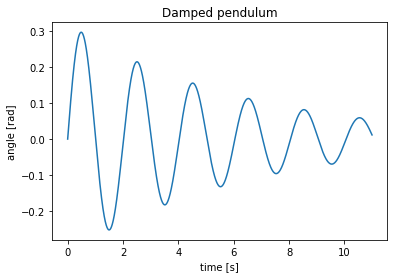

In [7]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, seed

from echo_state_network import ESN

gamma = 3
damping = 0
K = 12
omega = 4
g = 9.81

def pendulum(u, t):
    #Should return y', y''
    # angle'' = -g/l * sin(angle) - damping * radius / mass * angle'
    
    return (u[1], -9.81 * np.sin(u[0]) - 4 * 0.8 / 10 * u[1])

t = np.linspace(0, 50, 10000)
solution = odeint(pendulum, [0, 1], t)
angle = solution[:,0]

plt.plot(t, angle)
plt.title('Damped pendulum')
plt.xlabel('time [s]')
plt.ylabel('angle [rad]')

indices = list(range(len(t)))
cutoff = int(len(solution) * 0.8)

# seed(6)
# shuffle(indices)

training_indices = indices[0:cutoff]
validation_indices = indices[cutoff:]

training_input = t[sorted(training_indices)]
training_output = angle[sorted(training_indices)]

validation_input = t[sorted(validation_indices)]
validation_output = angle[sorted(validation_indices)]

AVERAGE LOSS: 3.348069630217993e-15


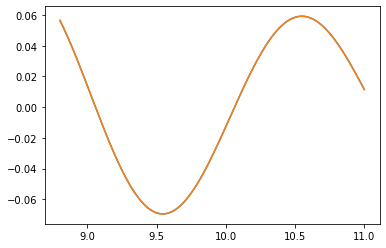

In [9]:
esn = ESN(
    1, 
    1, 
    n_reservoir=100, 
    spectral_radius=0.8, 
    sparsity=0.1, # number of nodes connected / max number of links 
    noise=0, 
    input_shift=None,
    input_scaling=None, 
    teacher_forcing=True, 
    feedback_scaling=None,
    teacher_scaling=None, 
    teacher_shift=None,
    out_activation=lambda x: x, #tanh, sigmoid
    inverse_out_activation=lambda x: x, #TODO ?
    random_state=None, 
    silent=True
)

esn.fit(training_input, training_output)[:,0]

predictions = np.array([])

i = 1
d = len(validation_input)

for v_input in validation_input:
    prediction = esn.predict(np.array([v_input]))
    predictions = np.append(predictions, prediction[0][0])
    
    training_input = np.append(training_input, v_input)
    training_output = np.append(training_output, validation_output[i - 1])
    
    esn.fit(training_input, training_output)
    
    print('done:', i/d * 100)
    i += 1

plt.clf()
plt.plot(validation_input, predictions, validation_input, validation_output)
    
print('AVERAGE LOSS:', ((predictions - validation_output) ** 2).mean())
    
# print(np.abs(training_result - training_output[:,0]).shape)
# print(training_input.shape)

# plt.plot(training_input, np.abs(training_result - training_output[:,0]))
# plt.plot(training_input, training_result[:,0], training_input, )

#TODO accuracy on number of steps (average)
#TODO training set needs to be smaller
#TODO 0-10s training, (10, 11] prediction
#TODO ARIMA - try prediction
#TODO LSTM

In [1]:
future_step = validation_input[0]
future_prediction = esn.predict(np.array([future_step]), True)[0][0]
truth = validation_output[0]

print(future_prediction, truth)
print('Difference:', np.abs(future_prediction - truth))

full_prediction = np.array([element[0] for element in esn.predict(validation_input, True)])

# TODO R2 evaluation
err = (full_prediction - validation_output) ** 2

print('cummulative error:', err.sum())

plt.plot(validation_input, full_prediction, validation_input, validation_output)

NameError: name 'validation_input' is not defined

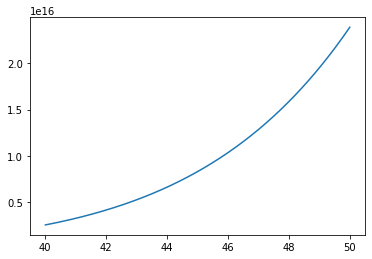

In [2]:
polynomial_fit = np.polyfit(training_input, training_output, 10)
polynomial = np.polynomial.Polynomial(polynomial_fit)
prediction = polynomial(validation_input)

plt.plot(validation_input, prediction)